# Импортируем библиотеки, загружаем данные, создаём методы

In [ ]:
import pandas as pd
import gdown
import ast
import json
import numpy as np
import requests
from datetime import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
!pip install pymorphy2
import pymorphy2
from scipy import stats
!pip install sweetviz
import sweetviz as sv
# !pip install pandas_profiling
# import pandas_profiling
from matplotlib import pyplot

In [ ]:
# Загружаем таблицу с гугл-диска
url = '15_FfenvHFoJVcPu6gGx9osLn71uDJ-Et'
output = "vacancies.csv"
gdown.download('https://drive.google.com/uc?export=download&id=' + url, output, quiet=False)

In [ ]:
df = pd.read_csv(output)

In [ ]:
# Подгружаем данные росстата по з/п с гугл-диска
url = '1mfzAkO00BX506VF-_yk_05r5iO72j6Y3'
output = "salary_gks.xlsx"
gdown.download('https://drive.google.com/uc?export=download&id=' + url, output, quiet=False)
df_gks = pd.read_excel(output)

In [48]:
def fill_prof_area(row):
  """
  Создаём метод, который заполняет словарь prof_area сферами и частотой их встречания в вакансиях
  Аргумент:
  row - множество
  """
  for el in row:
    if el in prof_areas:
      prof_areas[el] += 1
    else:
      prof_areas[el] = 1

In [49]:
def find_best_prof_area(row):
  """
  Создаём метод, который из всех специализаций выбирает ту, которая встречается чаще всего
  Аргумент:
  row - множество
  """
  max = 1
  for el in row:
    if prof_areas[el] > max:
      res = el
      max = prof_areas[el]
  return el

In [50]:
def plot_dict(d):
  """
  Создаём метод, который строит гистограмму для словаря
  Аргумент:
  d - словарь
  """
  pyplot.figure(figsize=(10, 10))
  pyplot.bar(d.keys(), d.values(), color='g')
  pyplot.xticks(rotation=45, ha="right");
  pyplot.show()

In [51]:
def plot_salary(df, col, Q, currency):
  """
  Создаём метод, который рисует распределение зарплат по какому-то параметру
  Аргументы:
  df - датафрейм
  col - по какому параметру (столбцу) строим распределение
  Q - выше какого-то перцентиля не учитываем з/п
  currency - бинарная переменная, нужно ли условие на российскую валюту
  """
  for el in df[col].dropna().unique():
    Q_from = np.nanpercentile(df['salary_from'][df[col] == el], Q)
    Q_to = np.nanpercentile(df['salary_to'][df[col] == el], Q)
    Q_avg = np.nanpercentile(df['salary_avg'][df[col] == el], Q)
    if currency:
      pyplot.hist(df['salary_avg'][df['salary_avg'] < Q_avg][df[col] == el][df['salary_currency'] == 'RUR']/1000, bins = 15, alpha=0.5, label='avg')
      pyplot.hist(df['salary_from'][df['salary_from'] < Q_from][df[col] == el][df['salary_currency'] == 'RUR']/1000, bins = 15, alpha=0.5, label='from')
      pyplot.hist(df['salary_to'][df['salary_to'] < Q_to][df[col] == el][df['salary_currency'] == 'RUR']/1000,bins = 15, alpha=0.5, label='to')
    else:
      pyplot.hist(df['salary_avg'][df['salary_avg'] < Q_avg][df[col] == el]/1000, bins = 15, alpha=0.5, label='avg')
      pyplot.hist(df['salary_from'][df['salary_from'] < Q_from][df[col] == el]/1000, bins = 15, alpha=0.5, label='from')
      pyplot.hist(df['salary_to'][df['salary_to'] < Q_to][df[col] == el]/1000,bins = 15, alpha=0.5, label='to')
    pyplot.legend(loc='upper right')
    pyplot.title(el)
    pyplot.xlabel("З/п, тыс.")
    pyplot.ylabel("Количество вакансий")
    pyplot.show()

In [89]:
def statistics(df, col, currency):
  """
  Создаём метод, который делает описательную статистику з/п по какому-то параметру (столбцу)
  Аргументы:
  df - датафрейм,
  col - по какому параметру (столбцу) строим распределение
  currency - бинарная переменная, нужно ли условие на российскую валюту
  """
  for el in df[col].dropna().unique():
    print(f'\n{el}\n')
    if currency:
      x = df[df[col] == el][df['salary_currency'] == 'RUR'].describe()[['salary_from', 'salary_to', 'salary_avg']]
    else:
      x = df[df[col] == el].describe()[['salary_from', 'salary_to', 'salary_avg']]
    s = x.style.format(formatter = '{:,.0f}')
    display(s)

# Исследуем переменные



In [52]:
# Удаляем идентичные столбцы
cols = ['billing_type_id', 'experience_id', 'employment_id', 'alternate_url', 'schedule_id', 'area_url', 'working_time_modes_id', 'type_id']
for col in cols:
  del df[col]

In [53]:
# Получаем все города и их parent_id
req = requests.get('https://api.hh.ru/areas')  # Посылаем запрос к API
data = req.content.decode()  # Декодируем его ответ, чтобы Кириллица отображалась корректно
req.close()
jsonObj = json.loads(data)
cities, countries_name, areas_name = [], [], []
for i in range(len(jsonObj)):
    for area in jsonObj[i]['areas']:
      if area['areas'] == []:
        cities.append(area)
        countries_name.append(jsonObj[i]['name'])
        areas_name.append(area['name'])
      else:
        for city in area['areas']:
          cities.append(city)
          countries_name.append(jsonObj[i]['name'])
          areas_name.append(area['name'])
df_cities = pd.DataFrame(cities)
df_cities['country_name'] = countries_name
df_cities['areas_name'] = areas_name

In [54]:
# Переименовываем столбец
df_cities['area_id'] = df_cities['id']
df_cities = df_cities.drop('id', 1)

In [55]:
# Конвертируем в формат int, чтобы сопоставить
df_cities['area_id'] = df_cities['area_id'].astype(str).astype(int)

In [56]:
# Присваиваем каждой строке имя региона и страны
df['areas_name'] = df['area_id'].map(df_cities.set_index('area_id')['areas_name'])
df['country_name'] = df['area_id'].map(df_cities.set_index('area_id')['country_name'])

In [57]:
# Считаем среднюю з/п
df['salary_avg'] = (df['salary_from'] + df['salary_to'])/2

In [58]:
# Вместо списка делаем множество (т.к. значения в списке повторяются)
cols = ['specializations_profarea_name', 'specializations_name']
for col in cols:
  df[col] = df[col].apply(lambda x: set(eval(x))).astype(str)

In [ ]:
report = sv.analyze(df)

In [ ]:
report.show_html('common analysis.html')

In [ ]:
pandas_profiling.ProfileReport(df)

In [ ]:
profile

# Зарплата

In [ ]:
# Для тех вакансий, у которых з/п указана после вычета налогов делаем ее до вычетов
df['salary_avg'][(df['salary_gross'] == False) & ((df['country_name'] == 'Россия') | (df['country_name'] == 'Беларусь'))] = df['salary_avg']/0.87
df['salary_avg'][(df['salary_gross'] == False) & ((df['country_name'] == 'Казахстан') | (df['country_name'] == 'Кыргызстан'))] = df['salary_avg']/0.9
df['salary_avg'][(df['salary_gross'] == False) & (df['country_name'] == 'Украина')] = df['salary_avg']/0.82
df['salary_avg'][(df['salary_gross'] == False) & (df['country_name'] == 'Грузия')] = df['salary_avg']/0.8

In [60]:
%matplotlib inline

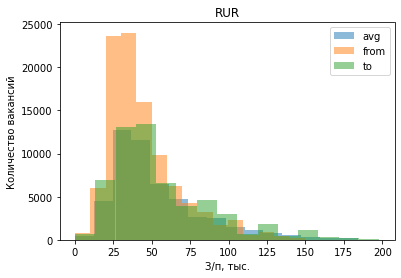

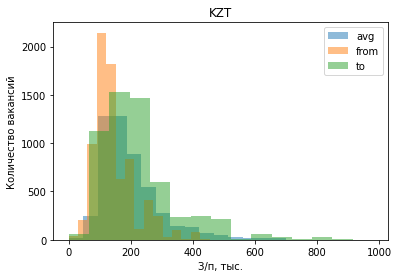

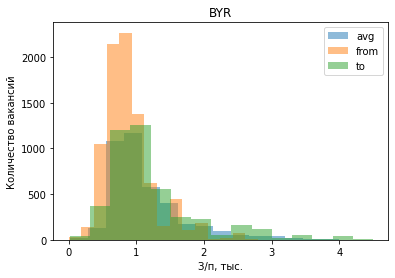

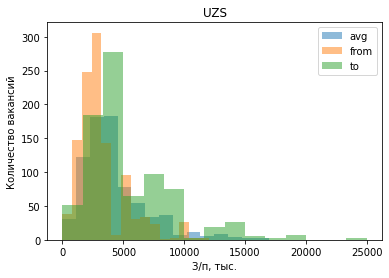

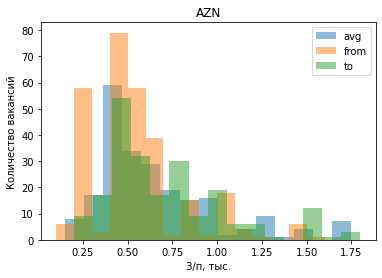

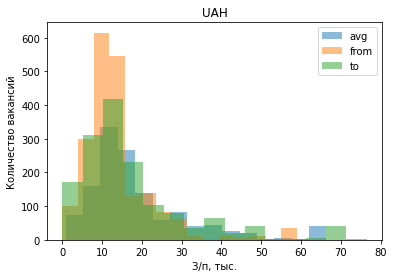

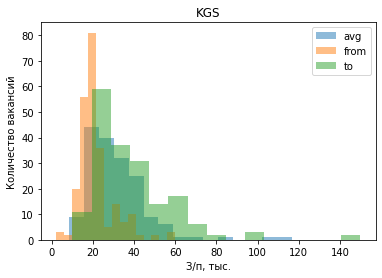

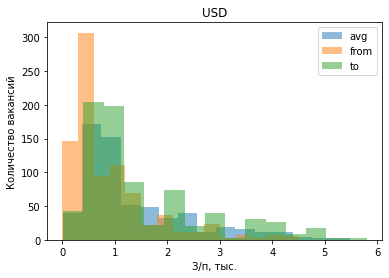

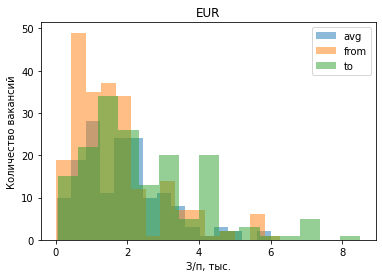

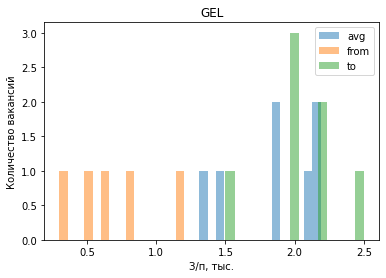

In [61]:
# Рисуем гистограммы распределения з/п для каждой валюты
plot_salary(df, 'salary_currency', 99, False)

In [62]:
# Считаем средние з/п по всем регионам
x = pd.DataFrame(df[df['country_name'] == 'Россия']['salary_avg'].groupby(df['areas_name']).mean())
x['areas_name'] = x.index

In [63]:
x['salary_gks'] = x['areas_name'].map(df_gks.set_index('areas_name')['salary_avg'])

In [64]:
# Считаем, насколько посчитанная средняя зарплата отличается от данных с росстата за июнь в рублях
(abs(x['salary_gks'] - x['salary_avg'])).mean()

11432.515911638991

In [65]:
# Корреляция
x['salary_gks'].corr(x['salary_avg'])

0.8216696340647939

In [66]:
x = x.dropna()
stats.ttest_ind(x['salary_avg'],x['salary_gks']) # p-value > 0.05, значит принимаем нулевую гипотезу, 2 independent samples have identical average (expected) values

Ttest_indResult(statistic=1.0972037012643767, pvalue=0.27416075621108865)

In [90]:
# Описательная статистика для з/п
statistics(df, 'salary_currency', False)


RUR



,salary_from,salary_to,salary_avg
count,"101,182","57,546","50,956"
mean,"44,008","59,099","55,614"
std,"31,296","45,509","38,678"
min,1,1,1
25%,"25,342","32,000","31,609"
50%,"35,000","46,000","45,000"
75%,"50,000","70,000","66,667"
max,"1,000,000","1,700,000","1,100,000"



KZT



,salary_from,salary_to,salary_avg
count,"7,817","5,695","5,064"
mean,"157,133","239,985","209,266"
std,"91,546","195,494","141,055"
min,70,650,600
25%,"100,000","150,000","133,333"
50%,"140,000","200,000","175,000"
75%,"185,000","300,000","250,000"
max,"1,500,000","5,000,000","2,888,889"



BYR



,salary_from,salary_to,salary_avg
count,"8,732","4,389","4,021"
mean,927,"1,323","1,197"
std,642,"1,233","1,102"
min,1,15,17
25%,650,800,775
50%,800,"1,000",970
75%,"1,000","1,500","1,351"
max,"40,000","50,000","51,724"



UZS



,salary_from,salary_to,salary_avg
count,"1,123",826,773
mean,"3,403,726","5,924,555","4,520,977"
std,"2,538,675","4,570,344","3,227,375"
min,1,1,1
25%,"2,000,000","3,000,000","2,500,000"
50%,"3,000,000","5,000,000","3,750,000"
75%,"4,000,000","8,000,000","5,500,000"
max,"25,000,000","30,000,000","25,000,000"



AZN



,salary_from,salary_to,salary_avg
count,295,227,227
mean,544,802,682
std,313,454,390
min,100,200,150
25%,400,500,450
50%,500,700,550
75%,600,"1,000",800
max,"2,500","3,500","3,000"



UAH



,salary_from,salary_to,salary_avg
count,"2,075","1,545","1,321"
mean,"14,522","19,232","19,713"
std,"12,044","16,792","15,000"
min,25,12,854
25%,"8,300","9,400","10,976"
50%,"12,000","14,000","15,000"
75%,"15,300","24,000","23,171"
max,"150,000","150,000","130,000"



KGS



,salary_from,salary_to,salary_avg
count,244,184,172
mean,"21,993","39,762","32,643"
std,"11,184","26,594","19,119"
min,"2,000","10,000","8,500"
25%,"15,000","25,000","22,222"
50%,"20,000","31,000","27,778"
75%,"25,000","47,000","37,500"
max,"100,000","200,000","150,000"



USD



,salary_from,salary_to,salary_avg
count,869,787,622
mean,"1,101","1,824","1,611"
std,"2,928","4,599","4,030"
min,1,15,15
25%,400,600,584
50%,600,"1,000",963
75%,"1,200","2,000","1,857"
max,"70,000","90,000","80,000"



EUR



,salary_from,salary_to,salary_avg
count,228,171,162
mean,"2,655","2,551","2,101"
std,"10,689","1,876","1,451"
min,8,60,35
25%,615,"1,375","1,222"
50%,"1,380","2,000","1,839"
75%,"2,000","3,311","2,708"
max,"150,000","10,000","8,125"



GEL



,salary_from,salary_to,salary_avg
count,8,8,8
mean,988,"2,175","1,977"
std,497,437,472
min,300,"1,500","1,312"
25%,575,"2,000","1,766"
50%,"1,000","2,100","2,000"
75%,"1,500","2,275","2,188"
max,"1,500","3,000","2,812"


# Исследуем сферы вакансий

In [68]:
df['specializations_profarea_name'] = df['specializations_profarea_name'].apply(lambda x: eval(x))

In [69]:
prof_areas = dict()
df['specializations_profarea_name'].apply(lambda x: fill_prof_area(x));

In [70]:
prof_areas = dict(sorted(prof_areas.items(), key=lambda item: -item[1]))

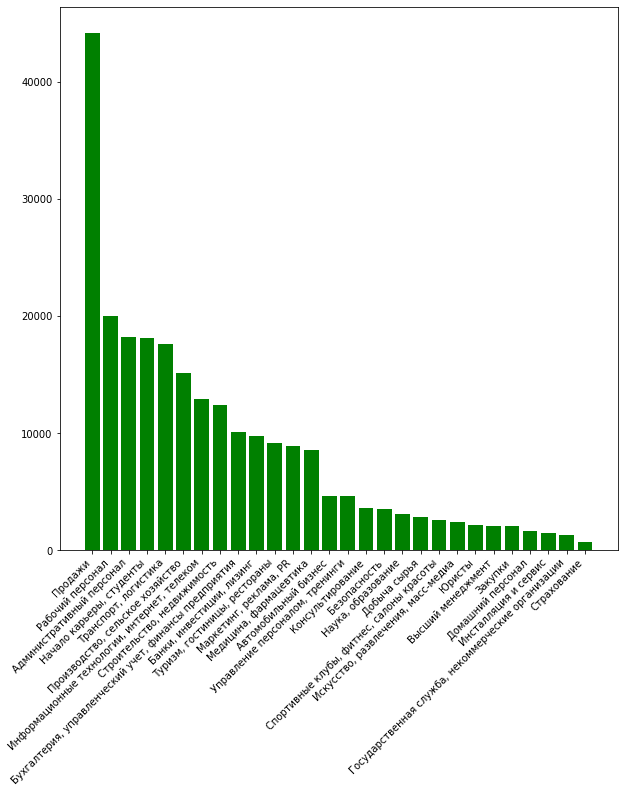

In [71]:
plot_dict(prof_areas)

In [72]:
df['prof_area'] = df['specializations_profarea_name'].apply(lambda x: find_best_prof_area(x))

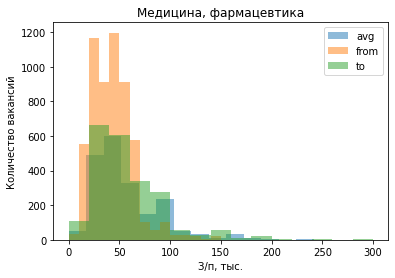

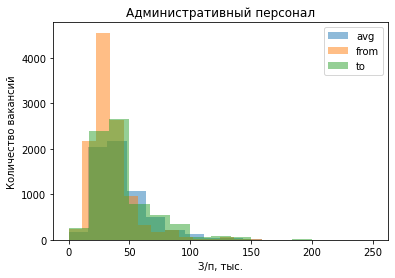

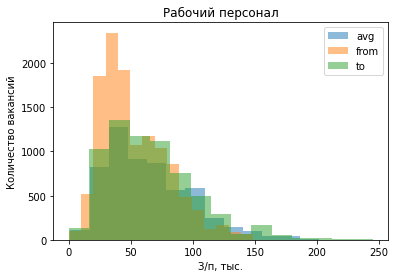

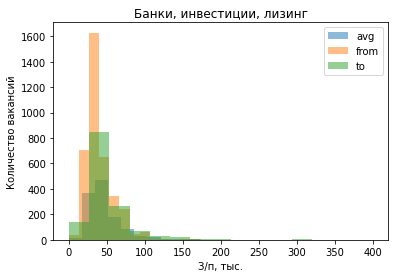

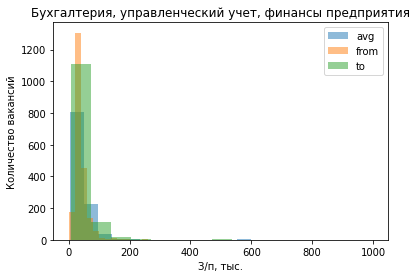

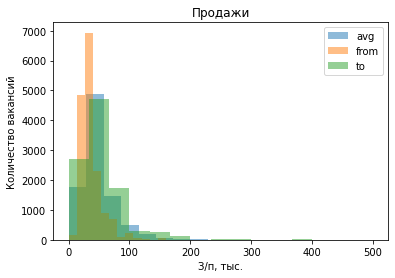

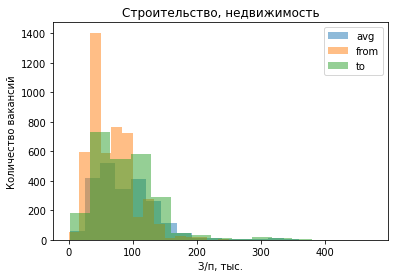

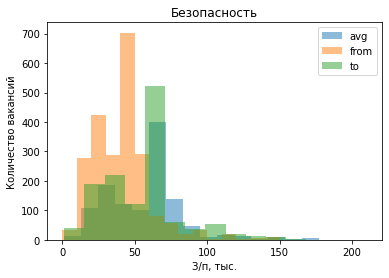

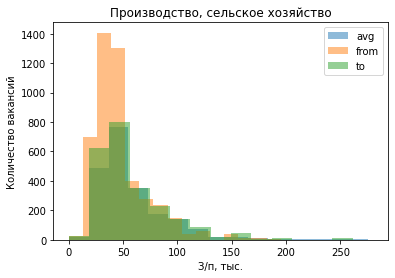

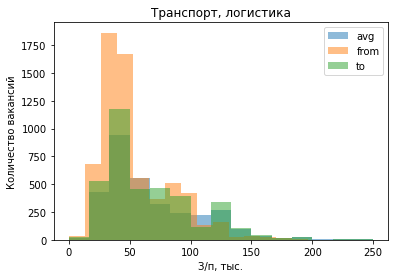

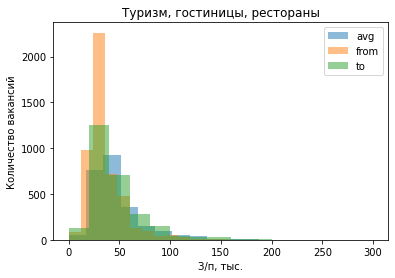

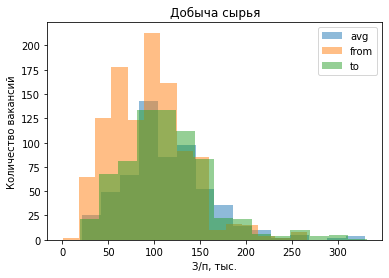

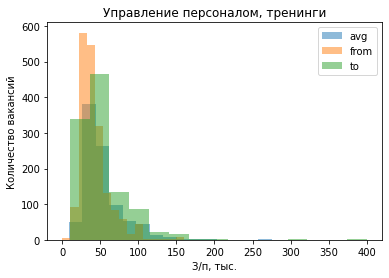

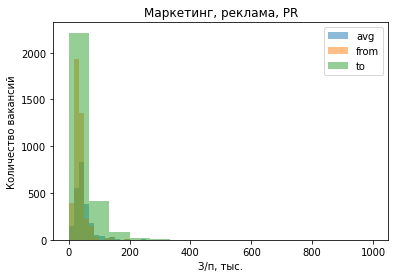

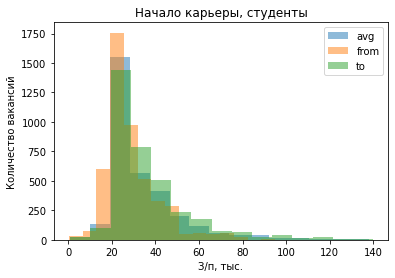

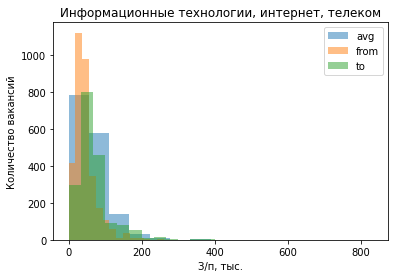

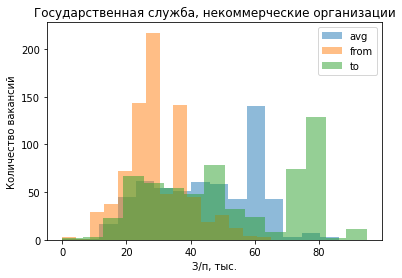

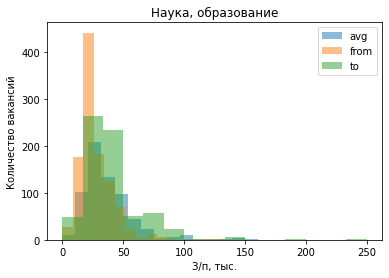

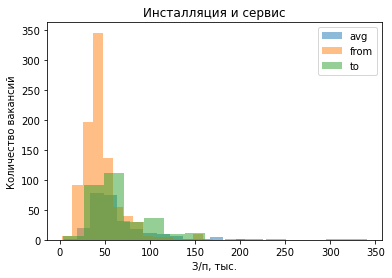

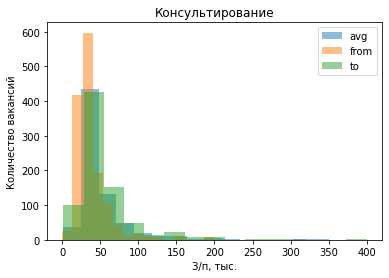

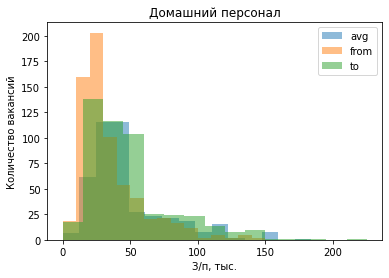

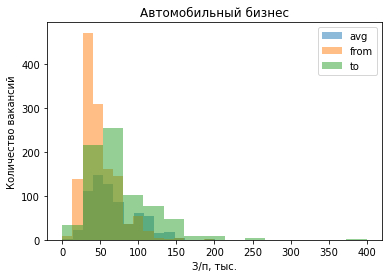

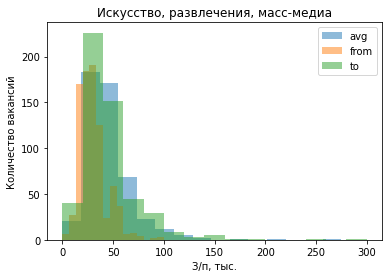

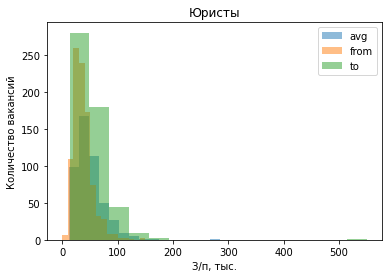

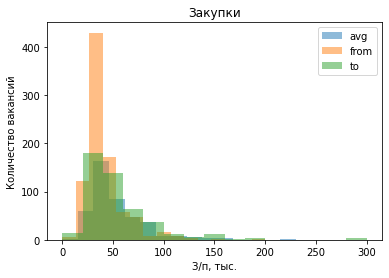

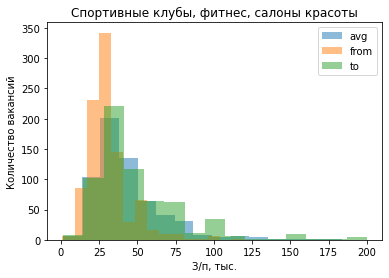

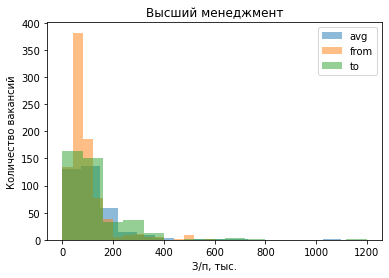

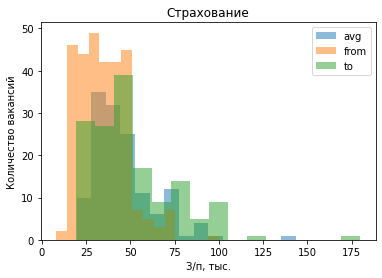

In [73]:
plot_salary(df, 'prof_area', 98, True)

In [91]:
statistics(df, 'prof_area', True)


Медицина, фармацевтика



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,salary_from,salary_to,salary_avg
count,"5,741","2,190","2,007"
mean,"46,734","63,417","58,853"
std,"25,728","44,017","38,614"
min,40,60,57
25%,"30,000","35,000","34,483"
50%,"45,000","50,000","48,772"
75%,"60,000","80,000","72,500"
max,"500,000","500,000","431,034"



Административный персонал



,salary_from,salary_to,salary_avg
count,"11,462","7,244","6,410"
mean,"34,034","45,906","43,626"
std,"18,476","29,584","24,383"
min,19,25,25
25%,"24,300","30,000","28,736"
50%,"30,000","40,000","37,500"
75%,"40,000","55,000","54,598"
max,"300,000","1,000,000","591,954"



Рабочий персонал



,salary_from,salary_to,salary_avg
count,"12,248","6,751","5,790"
mean,"52,108","67,378","66,151"
std,"29,920","43,052","38,806"
min,19,150,"1,370"
25%,"30,000","39,000","37,356"
50%,"45,000","60,000","57,471"
75%,"70,000","87,000","86,782"
max,"300,000","1,450,000","902,299"



Банки, инвестиции, лизинг



,salary_from,salary_to,salary_avg
count,"3,757","1,396","1,205"
mean,"41,897","51,259","49,020"
std,"20,579","33,579","27,103"
min,23,28,29
25%,"30,000","33,000","32,500"
50%,"38,000","40,000","40,230"
75%,"50,000","60,000","57,471"
max,"350,000","400,004","258,626"



Бухгалтерия, управленческий учет, финансы предприятия



,salary_from,salary_to,salary_avg
count,"2,161","1,245","1,087"
mean,"41,139","48,251","48,417"
std,"26,674","42,092","39,141"
min,40,"7,000","6,000"
25%,"30,000","30,000","32,500"
50%,"35,000","40,000","40,230"
75%,"45,000","50,000","51,724"
max,"500,000","1,000,000","689,655"



Продажи



,salary_from,salary_to,salary_avg
count,"16,326","9,930","8,949"
mean,"37,620","57,554","50,508"
std,"20,696","46,412","33,713"
min,20,25,26
25%,"25,000","32,000","30,632"
50%,"32,000","45,000","40,500"
75%,"45,000","70,000","59,195"
max,"500,000","1,086,000","647,126"



Строительство, недвижимость



,salary_from,salary_to,salary_avg
count,"4,793","2,487","2,251"
mean,"69,795","92,051","89,901"
std,"43,317","63,355","53,914"
min,50,"2,000","1,600"
25%,"40,000","50,000","51,724"
50%,"60,000","80,000","80,460"
75%,"90,000","120,000","115,000"
max,"1,000,000","1,000,000","650,000"



Безопасность



,salary_from,salary_to,salary_avg
count,"2,252","1,289","1,179"
mean,"43,276","56,547","56,797"
std,"22,671","28,385","27,729"
min,125,"1,500","1,250"
25%,"28,000","34,016","35,000"
50%,"45,000","65,000","63,218"
75%,"50,000","65,000","65,517"
max,"300,000","250,000","229,885"



Производство, сельское хозяйство



,salary_from,salary_to,salary_avg
count,"4,702","2,365","2,103"
mean,"50,544","60,299","59,369"
std,"55,691","39,166","37,611"
min,1,60,52
25%,"30,000","35,000","37,356"
50%,"40,000","50,000","48,851"
75%,"57,000","70,000","70,000"
max,"1,000,000","360,000","413,793"



Транспорт, логистика



,salary_from,salary_to,salary_avg
count,"6,515","3,721","3,177"
mean,"53,451","68,941","68,617"
std,"31,423","42,406","40,278"
min,30,45,38
25%,"30,850","40,000","40,000"
50%,"42,000","57,500","57,471"
75%,"70,000","90,000","91,954"
max,"499,999","800,000","600,000"



Туризм, гостиницы, рестораны



,salary_from,salary_to,salary_avg
count,"4,913","2,664","2,450"
mean,"36,591","51,846","48,914"
std,"27,291","40,557","38,430"
min,10,10,10
25%,"25,000","30,000","31,034"
50%,"30,000","40,000","40,230"
75%,"40,000","60,000","54,598"
max,"455,000","455,000","505,556"



Добыча сырья



,salary_from,salary_to,salary_avg
count,"1,106",708,596
mean,"96,421","116,201","115,230"
std,"45,426","50,430","50,030"
min,100,"19,000","21,839"
25%,"61,000","85,000","86,207"
50%,"94,000","110,000","109,195"
75%,"120,000","141,000","137,931"
max,"356,000","385,000","344,828"



Управление персоналом, тренинги



,salary_from,salary_to,salary_avg
count,"1,898","1,066",908
mean,"43,050","53,430","52,761"
std,"29,384","29,627","26,331"
min,50,"10,000","8,621"
25%,"30,000","35,000","35,000"
50%,"38,000","45,000","45,977"
75%,"50,000","60,000","60,345"
max,"600,000","400,000","275,000"



Маркетинг, реклама, PR



,salary_from,salary_to,salary_avg
count,"4,130","2,742","2,265"
mean,"35,360","49,857","47,102"
std,"22,137","41,141","29,796"
min,1,1,1
25%,"25,000","30,000","31,609"
50%,"30,000","40,000","40,230"
75%,"40,000","60,000","57,011"
max,"500,000","1,000,000","252,874"



Начало карьеры, студенты



,salary_from,salary_to,salary_avg
count,"4,841","3,570","3,217"
mean,"29,613","38,378","34,788"
std,"14,974","25,774","20,949"
min,200,850,747
25%,"21,000","25,000","23,000"
50%,"25,100","30,000","27,586"
75%,"35,000","45,000","40,000"
max,"420,000","500,000","258,621"



Информационные технологии, интернет, телеком



,salary_from,salary_to,salary_avg
count,"3,272","1,828","1,552"
mean,"45,374","71,600","66,563"
std,"31,888","57,883","45,278"
min,30,50,46
25%,"25,000","40,000","40,000"
50%,"40,000","60,000","55,000"
75%,"50,080","80,100","80,000"
max,"400,000","1,350,000","833,333"



Государственная служба, некоммерческие организации



,salary_from,salary_to,salary_avg
count,812,627,597
mean,"30,595","53,111","46,504"
std,"13,402","25,514","18,418"
min,33,37,41
25%,"25,000","32,000","31,609"
50%,"28,000","50,000","47,000"
75%,"35,000","75,000","62,069"
max,"250,000","320,000","200,000"



Наука, образование



,salary_from,salary_to,salary_avg
count,"1,075",694,643
mean,"27,425","41,620","36,770"
std,"14,092","26,648","19,941"
min,20,30,25
25%,"20,000","25,000","23,782"
50%,"25,000","35,000","32,184"
75%,"30,000","50,000","45,977"
max,"130,000","250,000","160,920"



Инсталляция и сервис



,salary_from,salary_to,salary_avg
count,932,302,263
mean,"45,901","68,673","65,662"
std,"22,768","41,133","37,753"
min,"3,000","4,000","4,598"
25%,"34,000","43,500","43,103"
50%,"42,000","57,000","54,598"
75%,"50,000","83,750","74,713"
max,"200,000","340,400","293,448"



Консультирование



,salary_from,salary_to,salary_avg
count,"1,452",787,709
mean,"39,489","57,824","52,045"
std,"28,400","47,387","36,483"
min,40,"1,500","1,322"
25%,"25,000","35,000","34,000"
50%,"34,600","46,000","41,250"
75%,"42,000","60,000","57,471"
max,"500,000","570,000","416,667"



Домашний персонал



,salary_from,salary_to,salary_avg
count,669,486,425
mean,"39,917","53,499","51,453"
std,"38,046","48,202","48,309"
min,10,15,14
25%,"20,000","30,000","28,736"
50%,"30,000","42,500","40,230"
75%,"47,500","60,000","57,471"
max,"400,000","600,000","517,241"



Автомобильный бизнес



,salary_from,salary_to,salary_avg
count,"1,354",750,686
mean,"49,732","76,036","67,280"
std,"23,804","41,740","30,917"
min,20,50,40
25%,"35,000","45,000","45,977"
50%,"45,000","68,750","57,600"
75%,"60,000","100,000","86,207"
max,"200,000","400,000","201,149"



Искусство, развлечения, масс-медиа



,salary_from,salary_to,salary_avg
count,846,513,488
mean,"31,499","50,275","45,755"
std,"18,756","43,365","34,835"
min,15,50,37
25%,"22,000","30,000","28,736"
50%,"30,000","40,000","40,115"
75%,"40,000","60,000","51,724"
max,"400,000","600,000","574,713"



Юристы



,salary_from,salary_to,salary_avg
count,944,517,473
mean,"39,679","52,527","50,161"
std,"18,084","34,261","26,134"
min,20,"13,000","12,069"
25%,"29,000","35,000","32,500"
50%,"35,000","45,000","45,977"
75%,"50,000","60,000","60,345"
max,"150,000","550,000","284,000"



Закупки



,salary_from,salary_to,salary_avg
count,868,471,419
mean,"42,402","58,065","53,084"
std,"20,396","37,448","28,598"
min,50,80,75
25%,"30,000","35,000","35,000"
50%,"40,000","50,000","45,977"
75%,"50,000","70,000","63,218"
max,"200,000","300,000","229,885"



Спортивные клубы, фитнес, салоны красоты



,salary_from,salary_to,salary_avg
count,952,651,614
mean,"30,491","51,791","45,197"
std,"15,469","35,575","27,809"
min,"1,000","1,500","1,552"
25%,"20,000","30,000","28,736"
50%,"25,000","40,000","37,500"
75%,"35,000","60,000","51,724"
max,"150,000","300,000","258,621"



Высший менеджмент



,salary_from,salary_to,salary_avg
count,867,402,355
mean,"95,813","136,923","120,691"
std,"80,664","140,788","102,320"
min,30,80,55
25%,"50,000","65,000","60,000"
50%,"70,000","100,000","94,828"
75%,"100,000","150,000","147,026"
max,"800,000","1,700,000","1,100,000"



Страхование



,salary_from,salary_to,salary_avg
count,294,150,138
mean,"35,152","53,536","46,555"
std,"14,978","23,957","18,658"
min,"8,000","19,300","19,600"
25%,"25,000","38,500","32,565"
50%,"35,000","50,000","42,500"
75%,"40,000","70,000","54,598"
max,"150,000","180,000","143,678"


# Анализируем описание вакансий

In [74]:
# Избавляемся от html-кода в столбце 'description'
code = ['<li>', '</li>', '<strong>', '</strong>','<p>', '</p>','<ul>', '</ul>','&quot', '<em>', '<br />']
for word in code:
  df['description'] = df['description'].str.replace(word, '')

In [75]:
# Считаем наиболее часто встречающиеся слова в описании вакансий, за исключением stopwords и небуквенных символов
s = df['description'].to_string()

In [76]:
allWords = nltk.tokenize.word_tokenize(s)
stopwords = nltk.corpus.stopwords.words('russian')

In [77]:
symbols = ['<', '>', '...', ',', '-', '.', ';', ':', '«', '»', '!', '(', ')', '/', '–', '—', '&']

In [78]:
morph = pymorphy2.MorphAnalyzer()

In [79]:
allWordExceptStopDist = nltk.FreqDist(morph.parse(w.lower())[0].normal_form for w in allWords if w.lower() not in symbols and w.lower() not in stopwords)   

In [80]:
mostCommon = dict(Counter(allWordExceptStopDist).most_common(20))

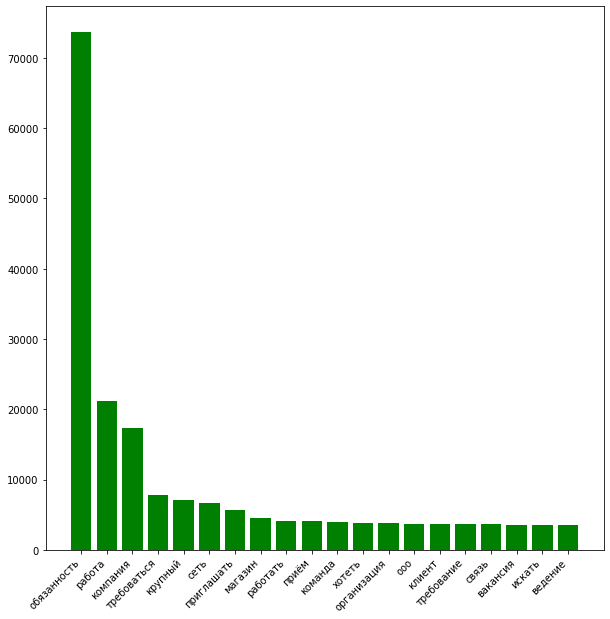

In [81]:
plot_dict(mostCommon)